<a href="https://www.kaggle.com/code/yaaangzhou/s3e18-version-6-eda-fs-and-more-baselines?scriptVersionId=138466263" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install flaml
!pip install -q pygwalker
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.5/260.5 kB 5.2 MB/s eta 0:00:00


<h1 style="font-family:verdana;"> <center> 🎯PS3 E1: Forecasting Mini-Course Sales🚀</center> </h1>


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Version 6</p>

***This notebook contains the following: import data, EDA, feature engineering, build baseline models and an ensemble model.***

***In version 5, i added some more baseline models for each target.***

***In version 6, i add more EDA plots and 2 xgboost baseline models to predict EC1.***



# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Imports</p>

In [2]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pygwalker as pyg;

# Statistical Tests
from scipy.stats import f_oneway

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model Selection
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

# shap
import shap


# Models
import optuna
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from flaml import AutoML



import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

In [3]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [4]:
test = pd.read_csv('/kaggle/input/playground-series-s3e18/test.csv')
train = pd.read_csv('/kaggle/input/playground-series-s3e18/train.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s3e18/sample_submission.csv')

In [5]:
target = ['EC1','EC2']

train = train.drop(['id', 'EC3', 'EC4', 'EC5', 'EC6'], axis=1)
test = test.drop(['id'], axis=1)

# features category
cat = train.columns[train.nunique() < 10]
cat = cat.drop(target)

# features numerical
num = train.columns[~train.columns.isin(cat)]
num = num.drop(target)

print('The shape of train is: ', train.shape)
print('The shape of test is: ', test.shape)

print('The number of numerical features is: ', len(num))
print('The number of categorical features is: ', len(cat))

The shape of train is:  (14838, 33)
The shape of test is:  (9893, 31)
The number of numerical features is:  29
The number of categorical features is:  2


In [6]:
train.head()

BertzCT       Chi1     Chi1n      Chi1v     Chi2n      Chi2v     Chi3v  \
0  323.390782   9.879918  5.875576   5.875576  4.304757   4.304757  2.754513   
1  273.723798   7.259037  4.441467   5.834958  3.285046   4.485235  2.201375   
2  521.643822  10.911303  8.527859  11.050864  6.665291   9.519706  5.824822   
3  567.431166  12.453343  7.089119  12.833709  6.478023  10.978151  7.914542   
4  112.770735   4.414719  2.866236   2.866236  1.875634   1.875634  1.036450   

      Chi4n  EState_VSA1  EState_VSA2  ...  PEOE_VSA7  PEOE_VSA8  SMR_VSA10  \
0  1.749203     0.000000    11.938294  ...   0.000000   0.000000  17.744066   
1  1.289775    45.135471     0.000000  ...   0.000000   0.000000   7.822697   
2  1.770579    15.645394     6.606882  ...  53.378235   0.000000  15.645394   
3  3.067181    95.639554     0.000000  ...   0.000000   6.420822  15.645394   
4  0.727664    17.980451    12.841643  ...  19.386400   0.000000  11.938611   

    SMR_VSA5  SlogP_VSA3  VSA_EState9  fr_COO  fr_COO2  EC1  EC2  
0   0.000000    4.794537    35.527357       0        0    1    1  
1  30.705892   13.825658    44.707310       0        0    0    1  
2  73.143616   17.964475    45.660120       0        0    1    1  
3  62.107304   31.961948    87.509997       0        0    1    1  
4  18.883484    9.589074    33.333333       2        2    1    0  

[5 rows x 33 columns]

In [7]:
train.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

***In the original dataset, there were 29 continuous variables and 2 categorical variables. The scale of the data varies greatly, which means we need to scale them before training.***

In [8]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(train).style.background_gradient(cmap='Blues')

In [9]:
# Cross table betweem EC1 and EC2
pd.crosstab(train['EC1'], train['EC2']).style.background_gradient(cmap='Blues')

***There are also no missing values in the data. Some of the data appear to be unevenly distributed, and we will find out later if this is the case.***

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">EDA</p>

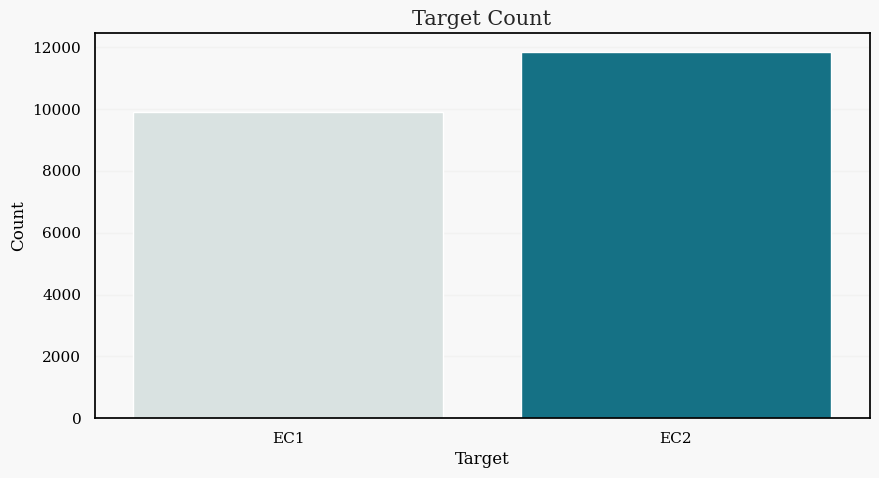

In [10]:
target_count = [train[i].sum() for i in target]
plt.figure(figsize=(10, 5))
sns.barplot(x=target, y=target_count, palette=['#D8E3E2','#037d97'])
plt.title('Target Count', fontsize=15)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

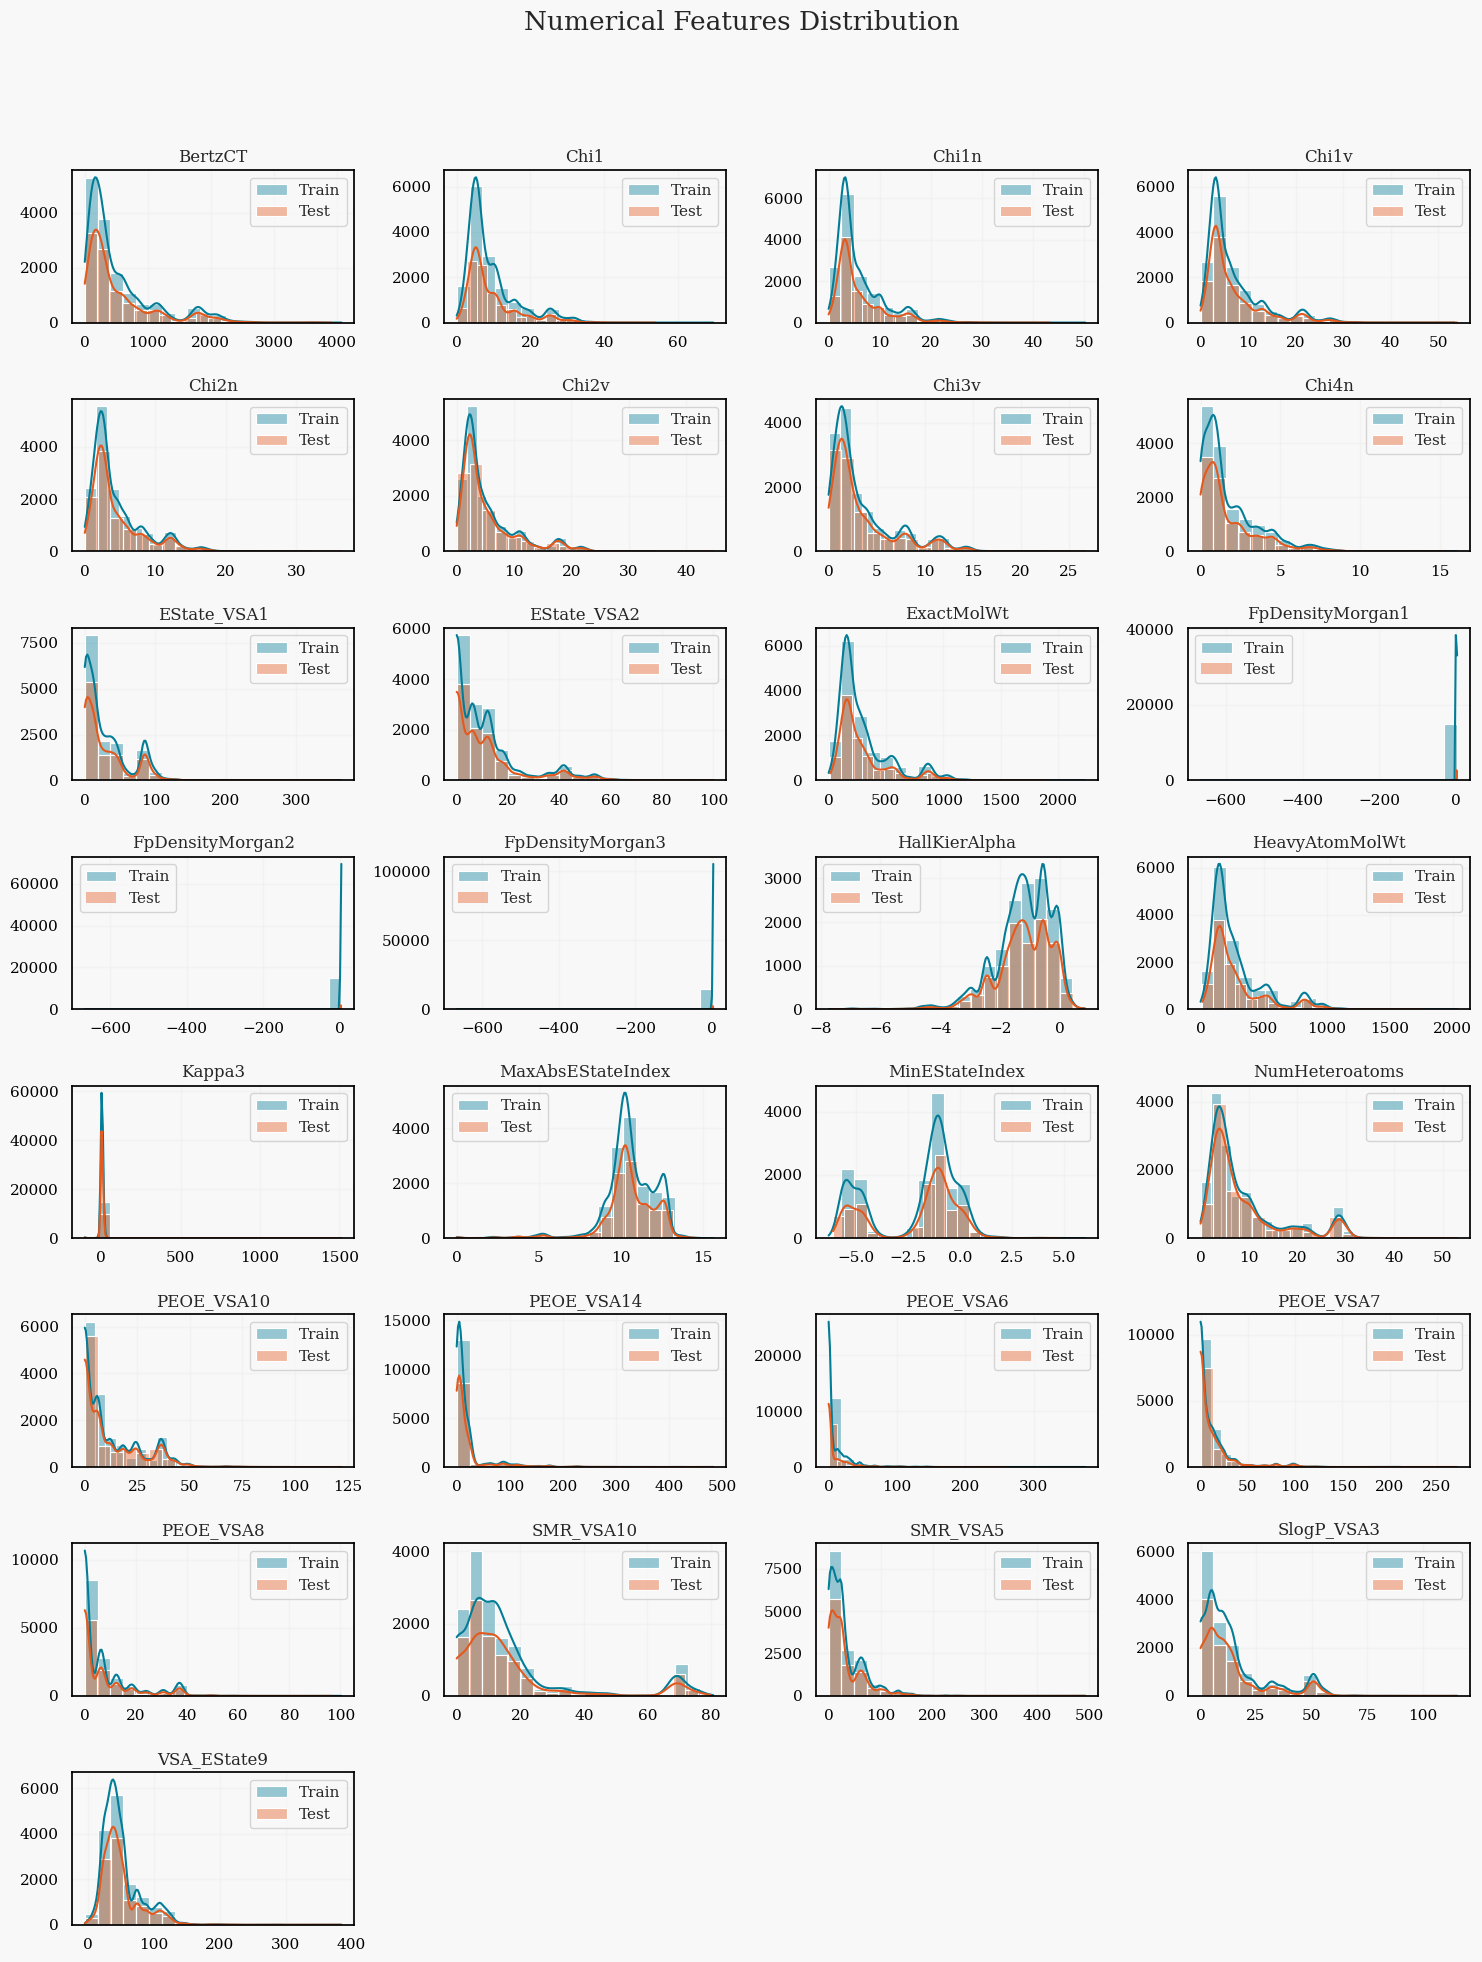

In [11]:
color_palette = palette

fig, axs = plt.subplots(8, 4, figsize=(15,20))
axs = axs.flatten()

for i, col in enumerate(num):
    ax = axs[i]
    sns.histplot(train[col], ax=ax, bins=20, label="Train", color=palette[1], alpha=0.4, kde=True)
    sns.histplot(test[col], ax=ax, bins=20, label="Test", color=palette[2], alpha=0.4, kde=True)

    ax.set_title(col, fontsize=12)
    ax.set_xlabel(None, fontsize=12)  
    ax.set_ylabel(None, fontsize=12)
    ax.legend()

for j in range(len(num), len(axs)):
    fig.delaxes(axs[j])

sns.set_palette(color_palette)
plt.tight_layout()
plt.suptitle('Numerical Features Distribution', fontsize=19)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

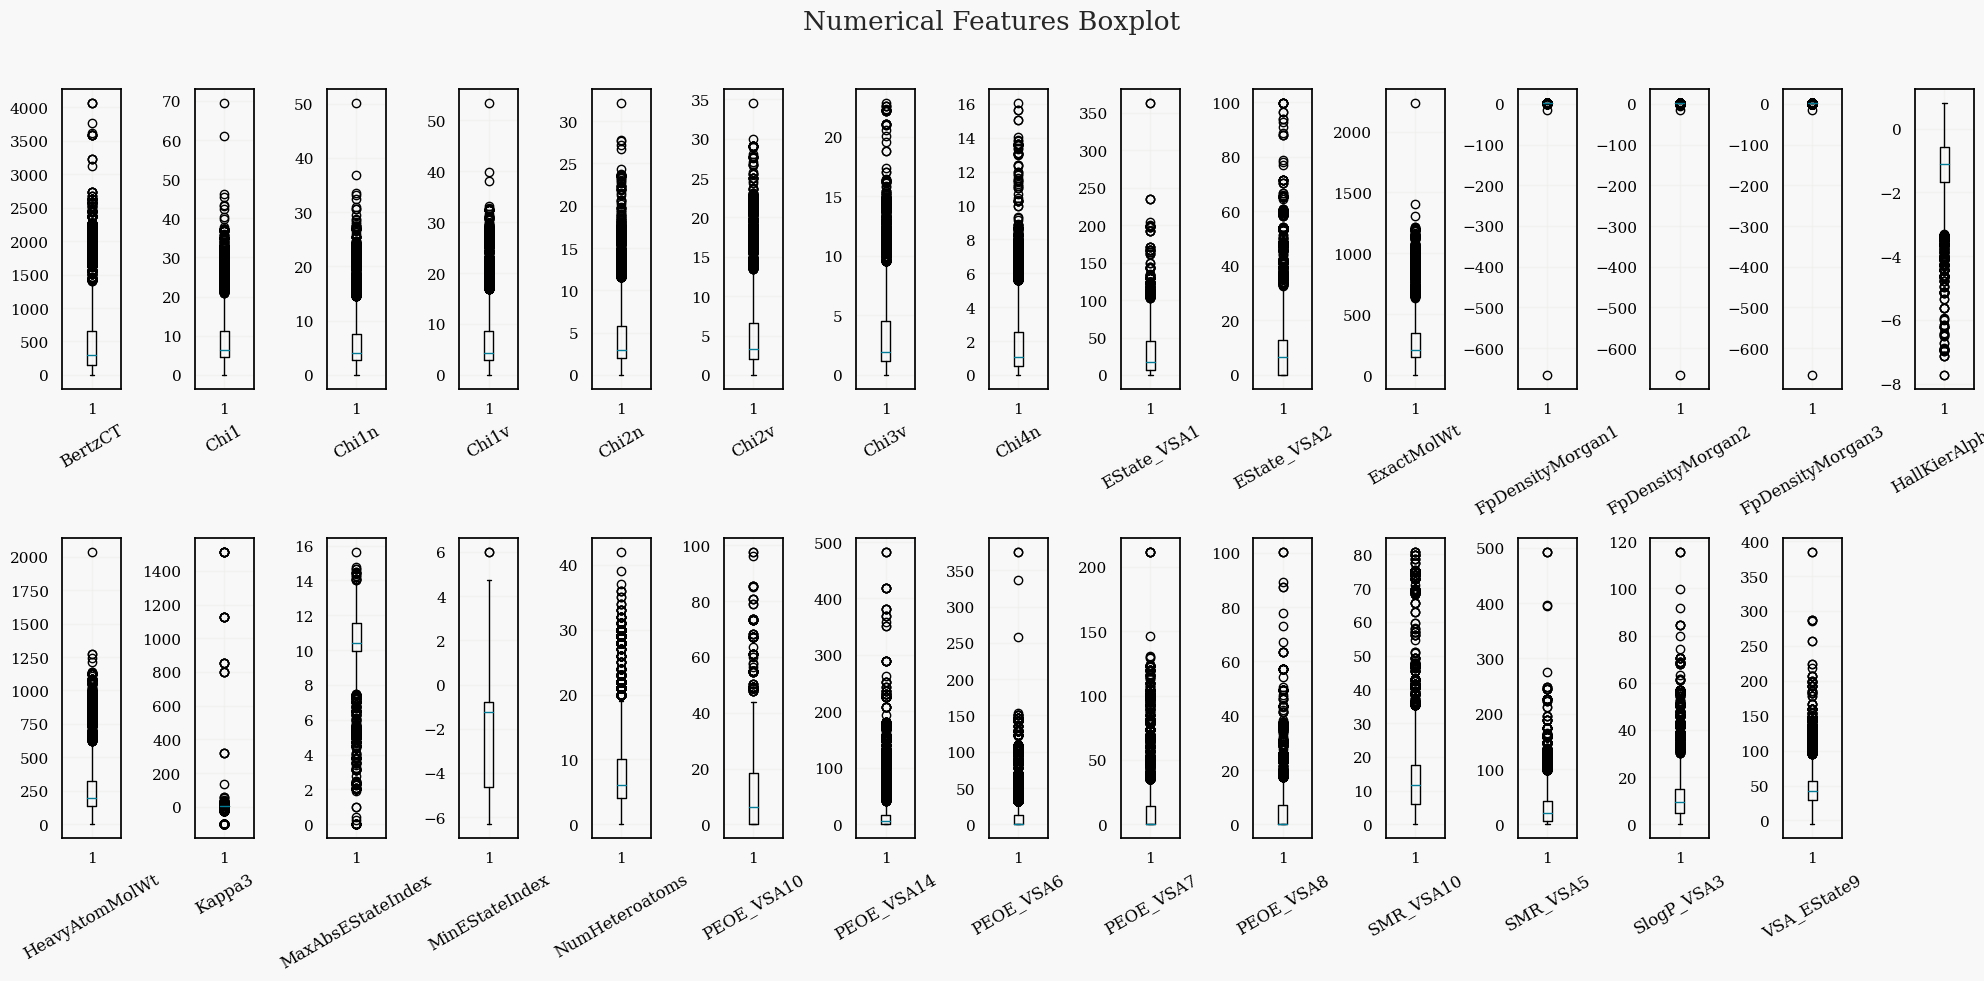

In [12]:
fig, axs = plt.subplots(2, len(num)//2+1, figsize=(20, 10))
axs = axs.flatten()
for i, col in enumerate(num):
    ax = axs[i]
    ax.boxplot(train[col])
    ax.set_xlabel(col, fontsize=12,rotation=30)

for j in range(len(num), len(axs)):
    fig.delaxes(axs[j])
    
plt.tight_layout()
plt.suptitle('Numerical Features Boxplot', fontsize=19)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

***You can ignore the following plot, which just integrates the two diagrams above.***

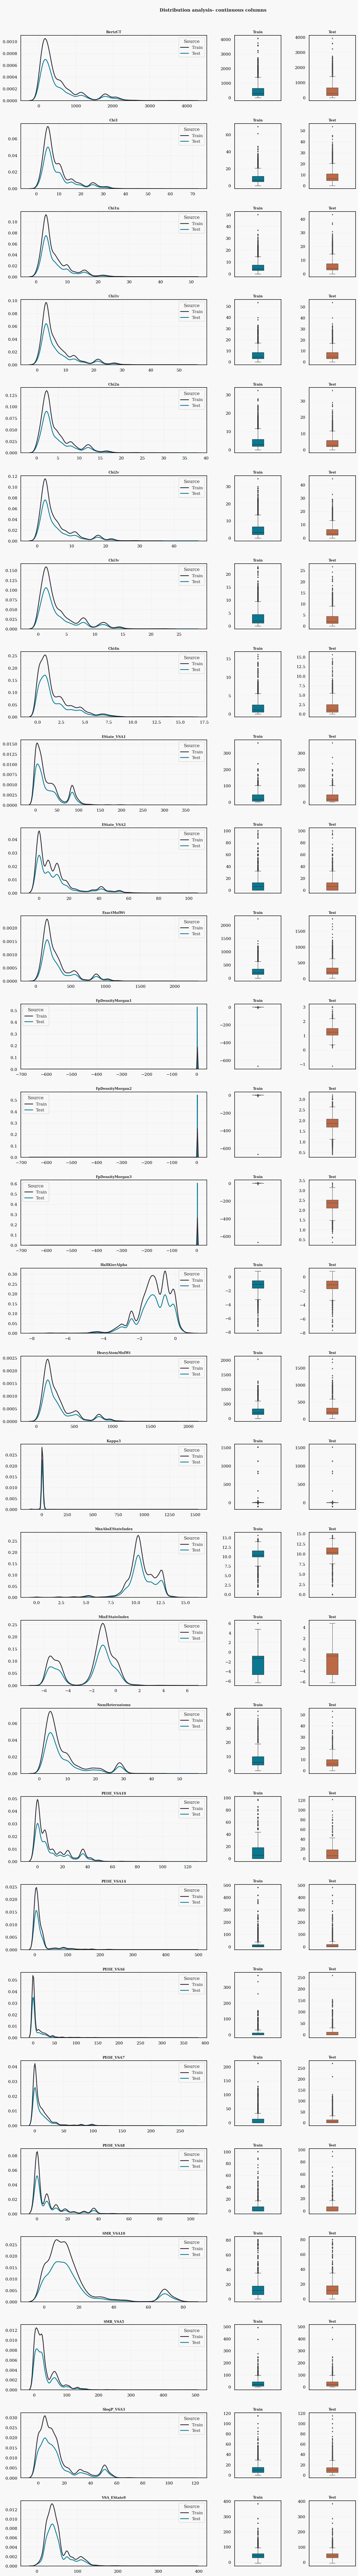

In [13]:
df = pd.concat([train[num].assign(Source = 'Train'), 
                test[num].assign(Source = 'Test')], 
               axis=0, ignore_index = True);

fig, axes = plt.subplots(len(num), 3 ,figsize = (16, len(num) * 4.2), 
                         gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]});

for i,col in enumerate(num):
    ax = axes[i,0];
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', ax = ax, linewidth = 2.1)
    ax.set_title(f"\n{col}",fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');

    ax = axes[i,1];
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',
                ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');

    ax = axes[i,2];
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                saturation = 0.6, linewidth = 0.90, color = '#E4591E',
                ax = ax); 
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Test",fontsize = 9, fontweight= 'bold');


plt.suptitle(f"\nDistribution analysis- continuous columns\n",fontsize = 12, fontweight= 'bold',
             y = 0.89, x = 0.57);
plt.tight_layout();
plt.show();

***Key points:***

***1. In terms of distribution, the skewness of some of them is relatively high.***

***2. Most of the features of the same name, their distribution is very similar.***

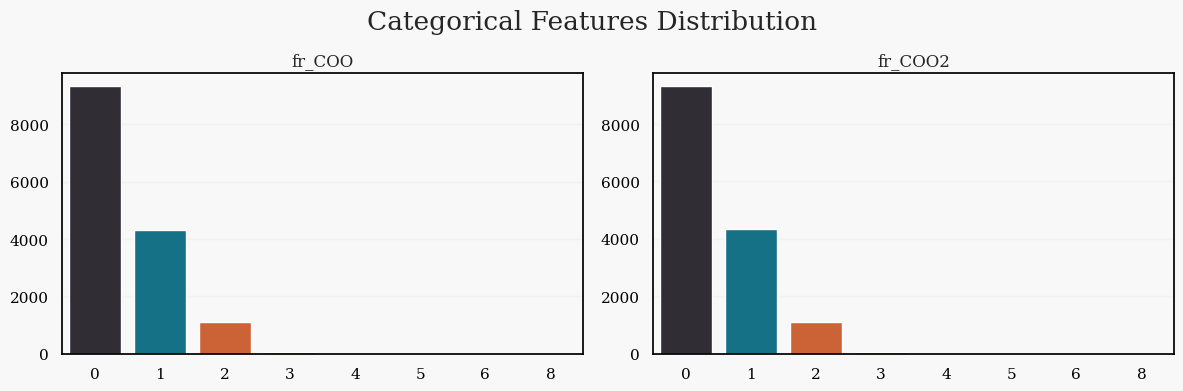

In [14]:
# features category

fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()

for i, col in enumerate(cat):
    ax = axs[i]
    sns.countplot(x=col, data=train, ax=ax, palette=palette)
    ax.set_title(col, fontsize=12)
    ax.set_xlabel(None, fontsize=12)  
    ax.set_ylabel(None, fontsize=12)

for j in range(len(cat), len(axs)):
    fig.delaxes(axs[j])

sns.set_palette(color_palette)
plt.tight_layout()
plt.suptitle('Categorical Features Distribution', fontsize=19)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

***Key point:***

***The distributions in the categorical variables were also inconsistent.***

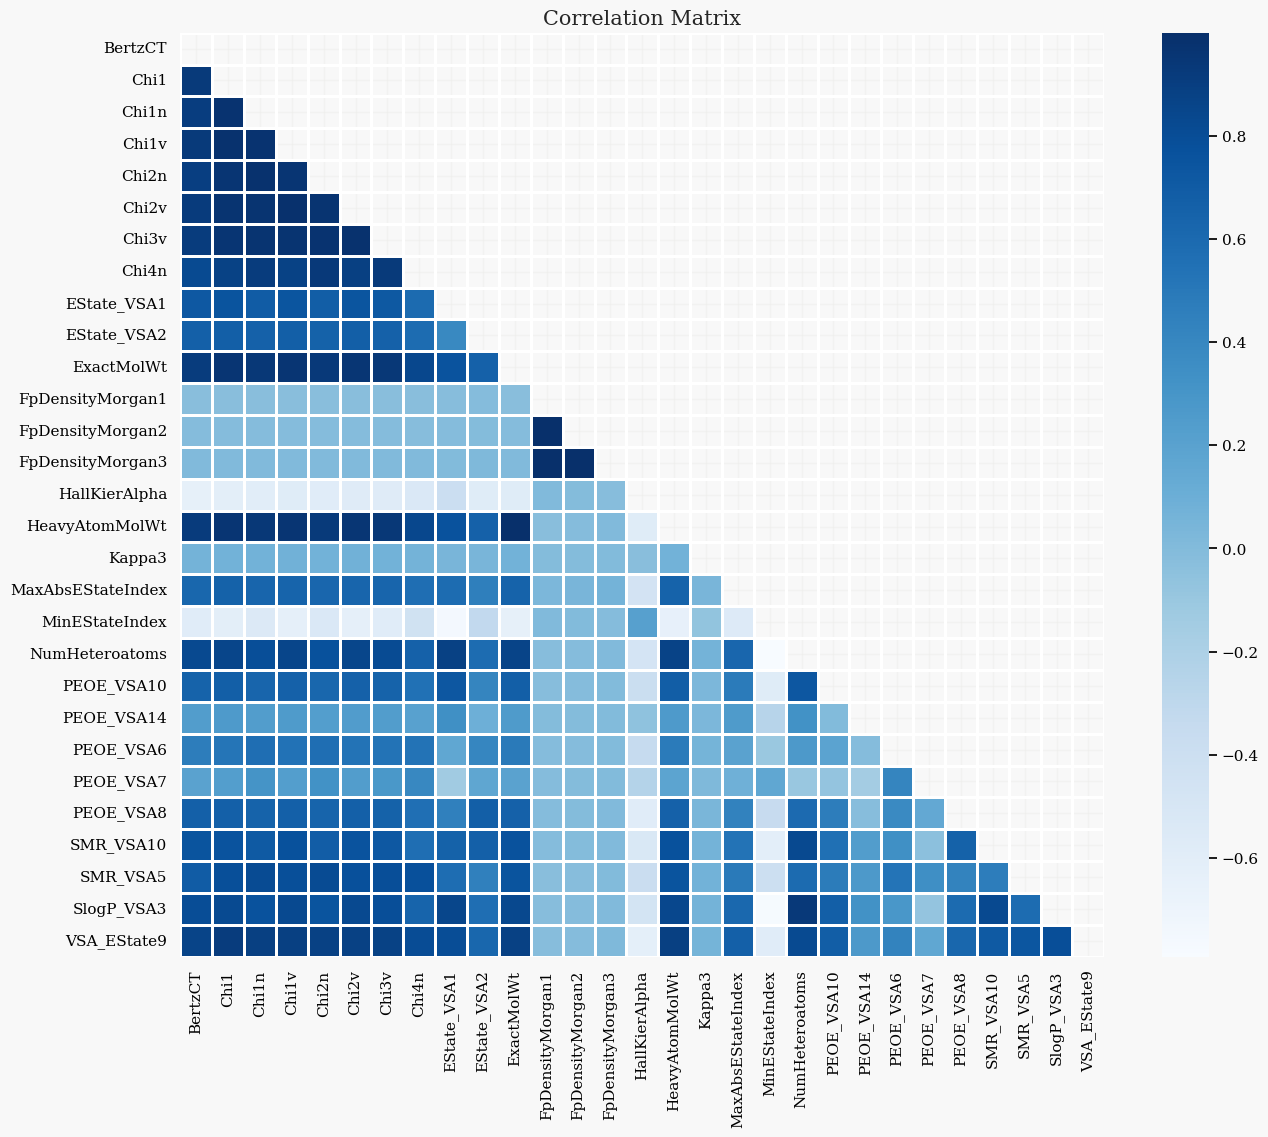

In [15]:
# Correlation

corr_matrix = train[num].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()


***Key point:***

***It is clear that many variables are highly correlated, the remarkable one being FpDensityMorgan1/2/3. Perhaps I should have kept just one of them.***

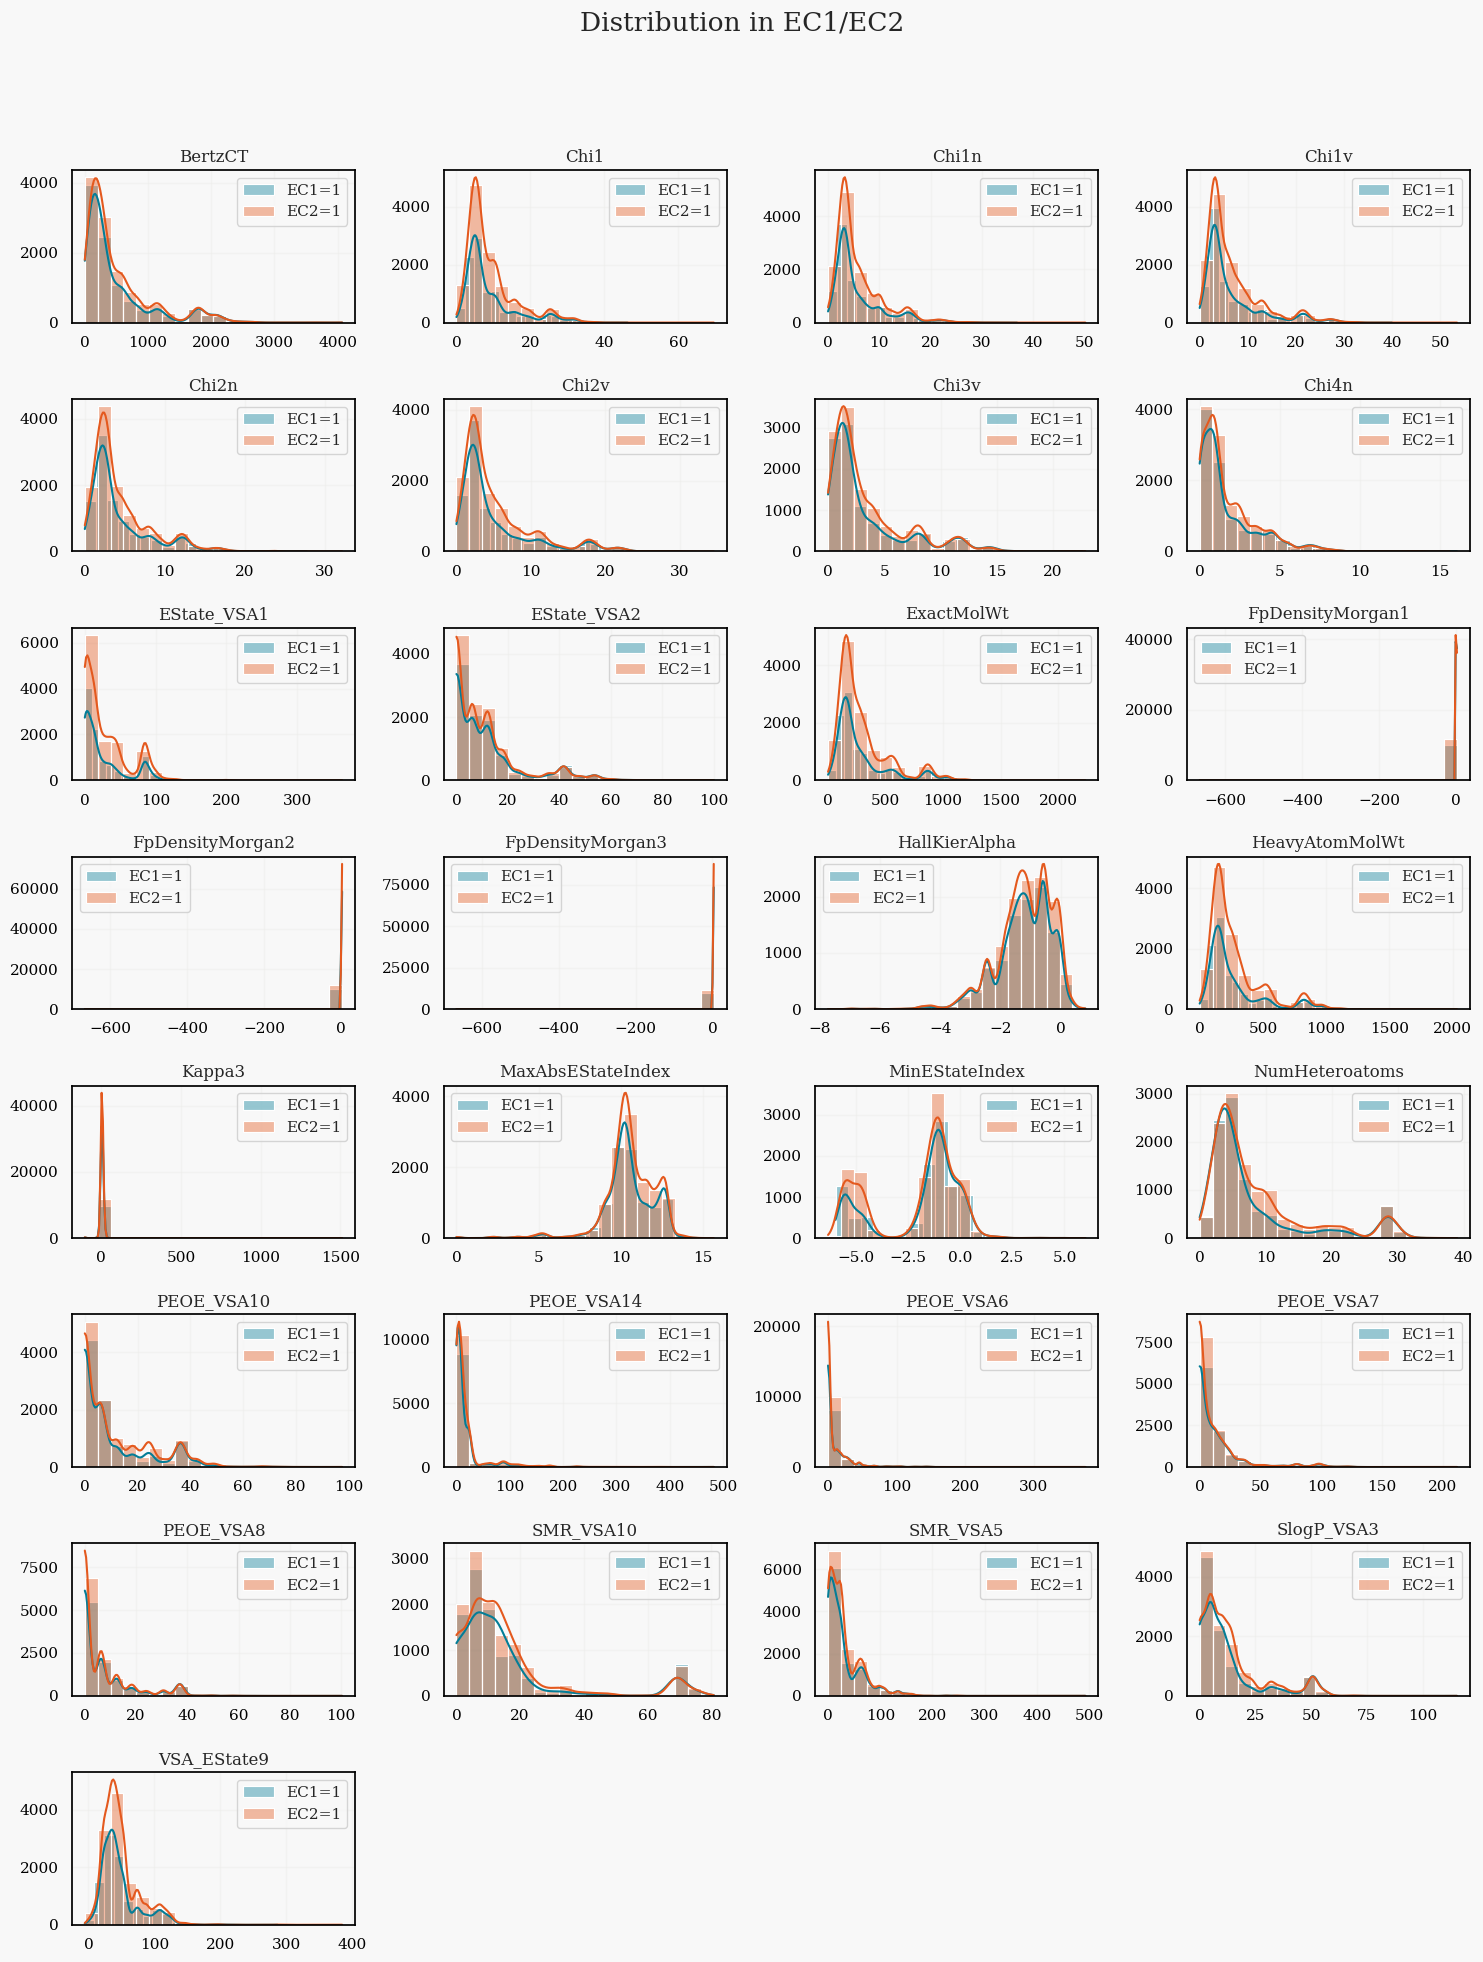

In [16]:
fig, axs = plt.subplots(8, 4, figsize=(15,20))
axs = axs.flatten()

for i, col in enumerate(num):
    ax = axs[i]
    sns.histplot(train[train['EC1']==1][col], ax=ax, bins=20, label="EC1=1", color=palette[1], alpha=0.4, kde=True)
    sns.histplot(train[train['EC2']==1][col], ax=ax, bins=20, label="EC2=1", color=palette[2], alpha=0.4, kde=True)

    ax.set_title(col, fontsize=12)
    ax.set_xlabel(None, fontsize=12)  
    ax.set_ylabel(None, fontsize=12)
    ax.legend()

for j in range(len(num), len(axs)):
    fig.delaxes(axs[j])

sns.set_palette(color_palette)
plt.tight_layout()
plt.suptitle('Distribution in EC1/EC2', fontsize=19)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

***Key point***

***The distribution in EC1/EC2 look similar.***

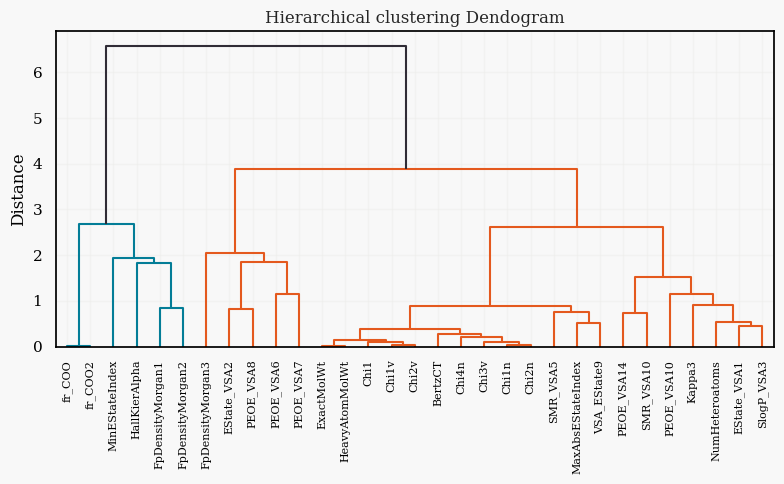

In [17]:
# hierarchical clustering
from scipy.cluster import hierarchy

spearman_corr = train.iloc[:,:-2].corr(method='spearman')
linkage_matrix = hierarchy.linkage(spearman_corr,method='complete')

fig,ax = plt.subplots(1,1,figsize=(8,5))
dendogram = hierarchy.dendrogram(linkage_matrix,ax=ax,labels=spearman_corr.columns.tolist())
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering Dendogram')
fig.tight_layout()

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966"> Pygwalker</p>

***I learned about this library from @RAVI RAMAKRISHNAN's notebook. i just wanted to try out this feature and it looks useful.***

***url:https://www.kaggle.com/code/ravi20076/playgrounds3e18-eda-baseline***

In [18]:
myplots = pyg.walk(train);

Box(children=(HTML(value='<div id="ifr-pyg-0" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966"> Data prepocessing</p>
***I am very cautious in feature engineering as I have little knowledge about it. However, i'm gonna drop those features with high correlation.***

In [19]:
num = num.drop(['FpDensityMorgan2', 'FpDensityMorgan3', 'Chi1v', 'Chi1n', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n'])
num

Index(['BertzCT', 'Chi1', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt',
       'FpDensityMorgan1', 'HallKierAlpha', 'HeavyAtomMolWt', 'Kappa3',
       'MaxAbsEStateIndex', 'MinEStateIndex', 'NumHeteroatoms', 'PEOE_VSA10',
       'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'SMR_VSA10',
       'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9'],
      dtype='object')

In [20]:
def replace_outliers(data):
    for col in num:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3-Q1
        
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        
        data[col] = np.clip(data[col], lower_bound, upper_bound)
    return data

def data_preprocessing(df):
    # drop useless data
    df.drop(['FpDensityMorgan2', 'FpDensityMorgan3', 'Chi1v', 'Chi1n', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n'],axis=1,inplace=True)   
    
    # replace outliners
    df = replace_outliers(df)

    # scaling
    scaler = StandardScaler()
    scaler.fit(df[num])
    df[num] = scaler.transform(df[num])
    df[num] = scaler.transform(df[num])
    return df


In [21]:
train = data_preprocessing(train)
test = data_preprocessing(test)

In [22]:
X_ec1 = train.drop(['EC2'],axis=1)
X_ec2 = train.drop(['EC1'],axis=1)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Baseline models + Feature selection</p>

In [23]:
feature = num.tolist() + cat.tolist()

In [24]:
def f_importance_plot(f_imp,title):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances {title}', size=16, y=1.05, 
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', linestyle="-", 
                    linewidth=0.5, edgecolor="black",palette='GnBu')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()
    
def show_confusion_roc(preds, target, title):   
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame({'preds': preds, 'target': target})
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap = 'Blues',ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds,  ax=ax[1])
    plt.suptitle(f'Confusion_ROC {title}', fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()

    
def get_mean_auc(oof, target):
    mean_val_auc = roc_auc_score(train[target], oof)
    return mean_val_auc

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Baseline models for EC1</p>

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_ec1.drop('EC1',axis=1), X_ec1['EC1'], train_size=0.8, random_state = 0)

In [26]:
models = {'XGBoost' : XGBClassifier(),
          'LightGBM': LGBMClassifier(),
          'CatBoost' : CatBoostClassifier(verbose = False),          
         }# 'LogisticRegression'  : LogisticRegression()

Training baseline model: XGBoost
Model Performance on validation set: 0.6751373668633592


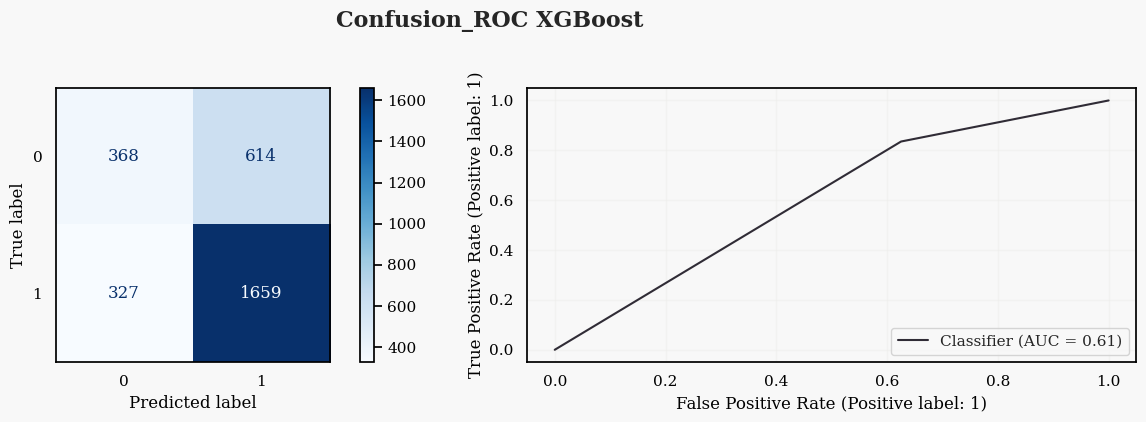

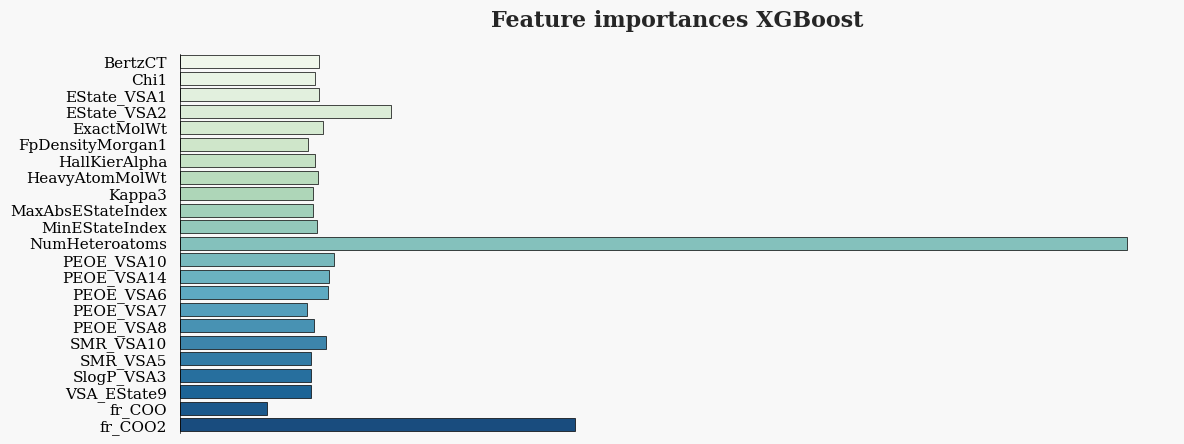

Training baseline model: LightGBM
Model Performance on validation set: 0.7028407098159621


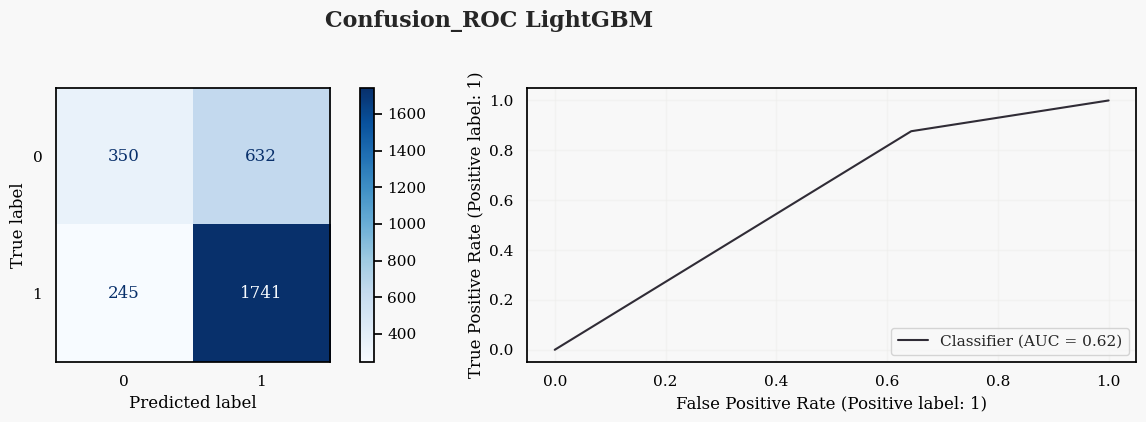

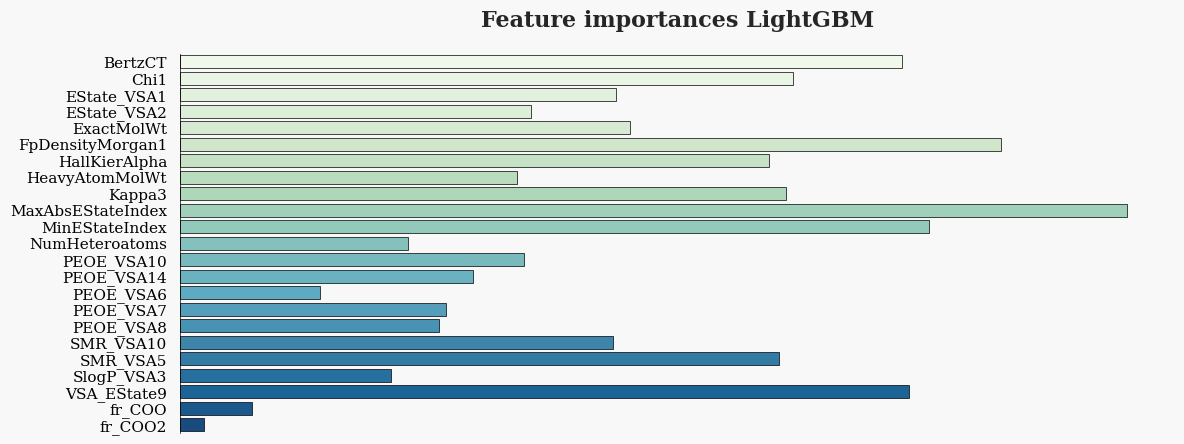

Training baseline model: CatBoost
Model Performance on validation set: 0.7093714043108276


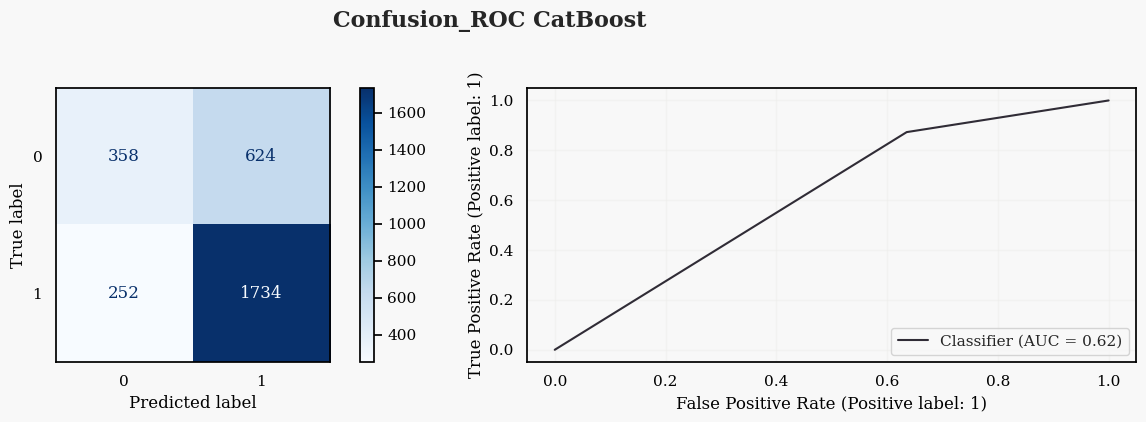

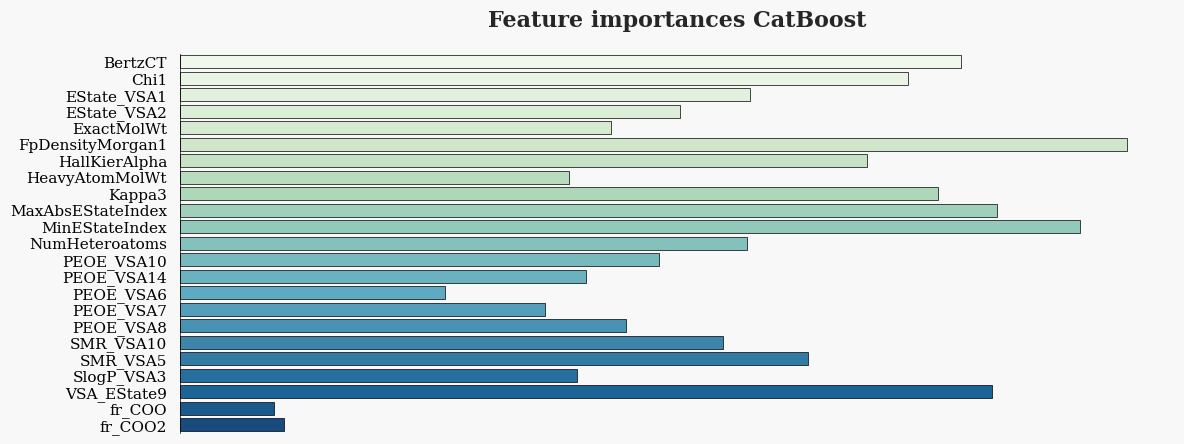

In [27]:
for i in range(len(models)):
    print(f'Training baseline model: {list(models.keys())[i]}')
    model = list(models.values())[i]
    model.fit(X_train,y_train.values)

    y_proba_pred = model.predict_proba(X_val)[:,1]
    val_roc = roc_auc_score(y_val, y_proba_pred)
    y_pred = model.predict(X_val)    

    print(f'Model Performance on validation set: {val_roc}')
    print('='*90)
    show_confusion_roc(y_pred, y_val,title=list(models.keys())[i])
    
    f_imp_df = pd.DataFrame({'feature': feature, 'avg_imp': model.feature_importances_})
    f_importance_plot(f_imp_df,list(models.keys())[i])    

***Looks like the best baseline model for EC1 is Catboost.***

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">RFE-CV</p>

In [28]:
for i in range(len(models)):
    min_features_to_select = len(X_train.columns) - 5
    
    print(f'Searching best features for : {list(models.keys())[i]}')
    model = list(models.values())[i]
    elimination = RFECV(model, step=1,min_features_to_select=min_features_to_select,cv=3,scoring='roc_auc', n_jobs=-1)
    elimination.fit(X_train, y_train)
    unnecessary_feature = list(X_train.columns[~elimination.get_support()])
    idx = np.argmax(elimination.cv_results_['mean_test_score'])
    removed_features = [f for i, f in enumerate(X_train.columns) if elimination.support_[i] == False]
    ranked_features = sorted(zip(X_train.columns, elimination.ranking_), key=lambda x: x[1])
    removed_features_by_ranking = [f[0] for f in ranked_features if f[0] in removed_features][::-1]
    print("Removed features:", removed_features_by_ranking)
    print(f'{"-" * 60}')    

Searching best features for : XGBoost
Removed features: ['fr_COO', 'MaxAbsEStateIndex', 'FpDensityMorgan1', 'SMR_VSA5', 'PEOE_VSA7']
------------------------------------------------------------
Searching best features for : LightGBM
Removed features: ['fr_COO2']
------------------------------------------------------------
Searching best features for : CatBoost
Removed features: ['fr_COO', 'fr_COO2', 'PEOE_VSA6', 'PEOE_VSA7', 'HeavyAtomMolWt']
------------------------------------------------------------


***Based on the results of RFECV, in the variables used to predict EC1, I will remove: `fr_COO2`, `fr_COO`,***

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Baseline models for EC2</p>

In [29]:
# XGBoost

X_train, X_val, y_train, y_val = train_test_split(X_ec2.drop('EC2',axis=1), X_ec2['EC2'], train_size=0.8, random_state = 41)

Training baseline model: XGBoost
Model Performance on validation set: 0.5666159449569153


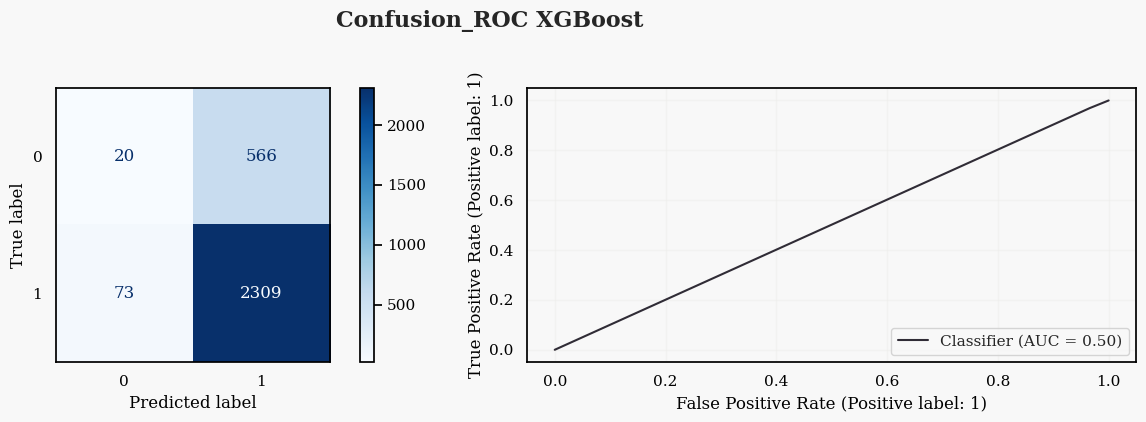

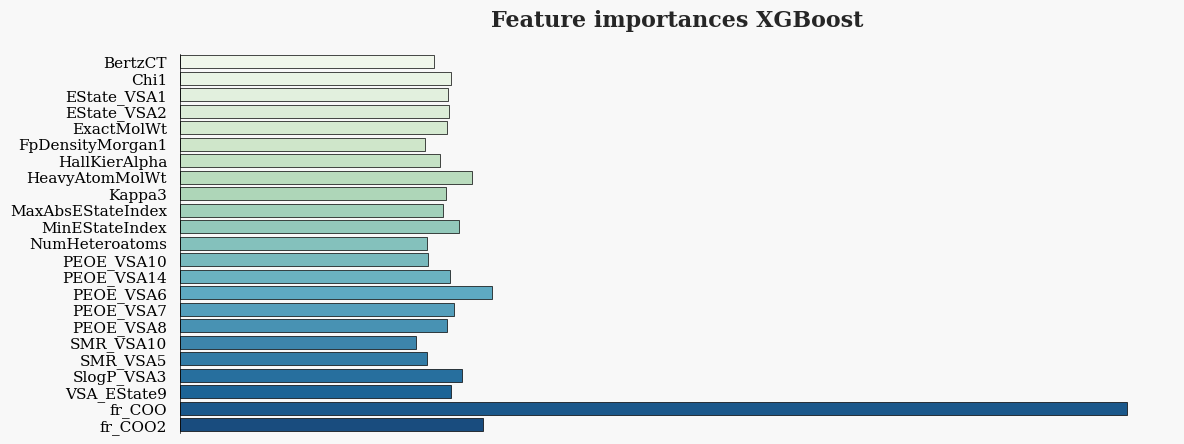

Training baseline model: LightGBM
Model Performance on validation set: 0.5660865192011759


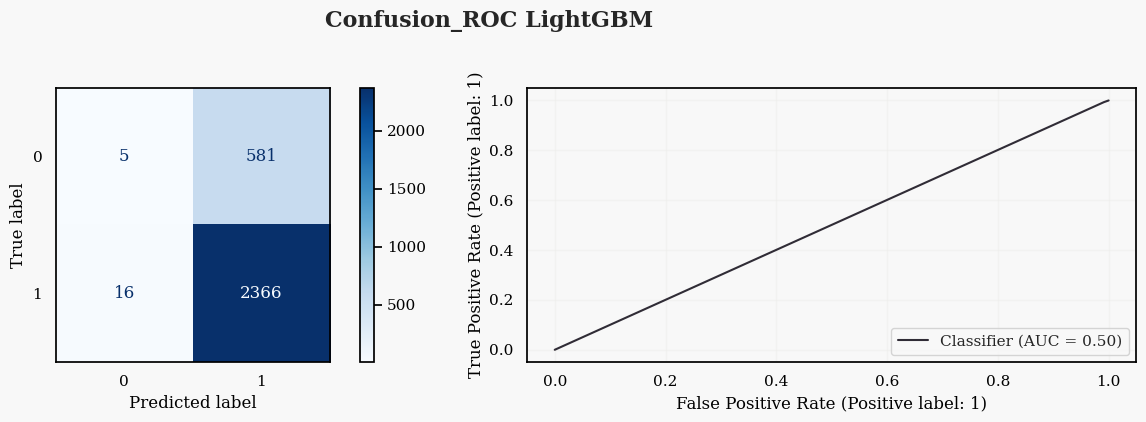

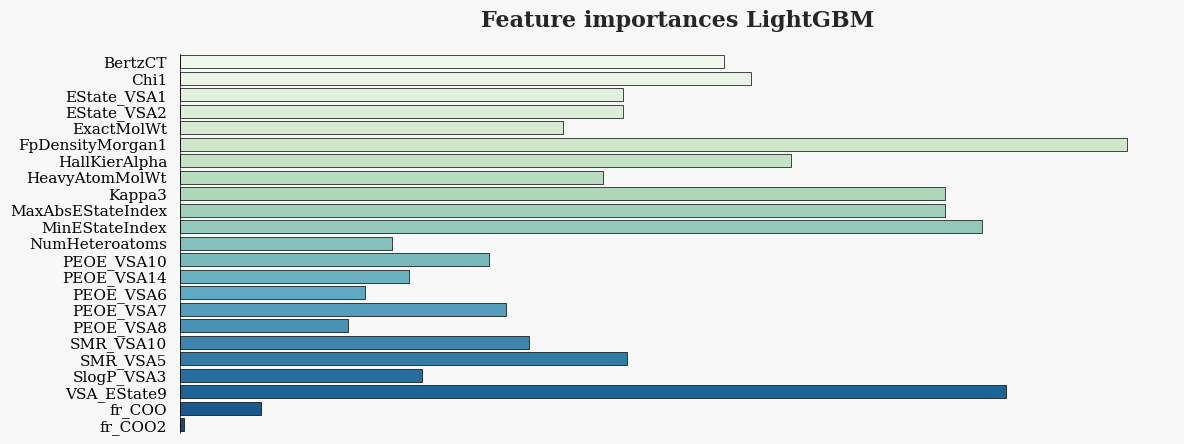

Training baseline model: CatBoost
Model Performance on validation set: 0.5649588924900347


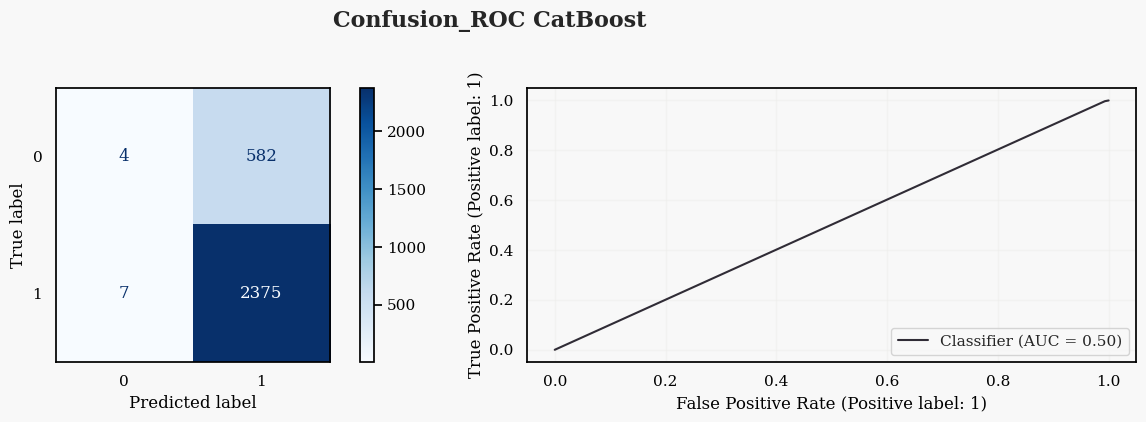

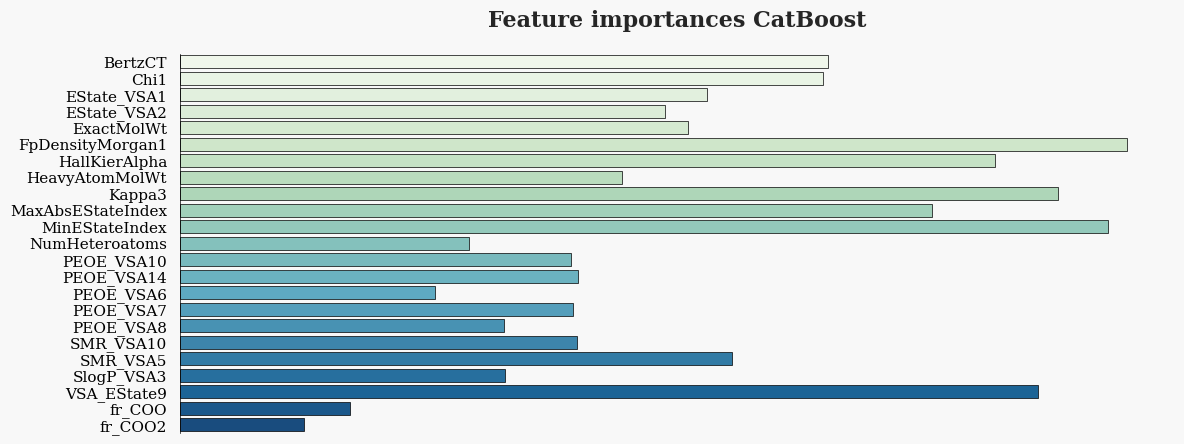

In [30]:
for i in range(len(models)):
    print(f'Training baseline model: {list(models.keys())[i]}')
    model = list(models.values())[i]
    model.fit(X_train,y_train.values)

    y_proba_pred = model.predict_proba(X_val)[:,1]
    val_roc = roc_auc_score(y_val, y_proba_pred)
    y_pred = model.predict(X_val)    

    print(f'Model Performance on validation set: {val_roc}')
    print('='*90)
    show_confusion_roc(y_pred, y_val,title=list(models.keys())[i])

    f_imp_df = pd.DataFrame({'feature': feature, 'avg_imp': model.feature_importances_})
    f_importance_plot(f_imp_df,list(models.keys())[i])  

***For EC2, none of these baseline models performed very well. Let's see if we can combine them into an ensemble model to improve the results.***

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">RFE-CV</p>

In [31]:
for i in range(len(models)):
    min_features_to_select = len(X_train.columns) - 5
    
    print(f'Searching best features for : {list(models.keys())[i]}')
    model = list(models.values())[i]
    elimination = RFECV(model, step=1,min_features_to_select=min_features_to_select,cv=3,scoring='roc_auc', n_jobs=-1)
    elimination.fit(X_train, y_train)
    unnecessary_feature = list(X_train.columns[~elimination.get_support()])
    idx = np.argmax(elimination.cv_results_['mean_test_score'])
    removed_features = [f for i, f in enumerate(X_train.columns) if elimination.support_[i] == False]
    ranked_features = sorted(zip(X_train.columns, elimination.ranking_), key=lambda x: x[1])
    removed_features_by_ranking = [f[0] for f in ranked_features if f[0] in removed_features][::-1]
    print("Removed features:", removed_features_by_ranking)
    print(f'{"-" * 60}')  

Searching best features for : XGBoost
Removed features: ['SMR_VSA10', 'NumHeteroatoms', 'fr_COO2']
------------------------------------------------------------
Searching best features for : LightGBM
Removed features: ['fr_COO2', 'fr_COO']
------------------------------------------------------------
Searching best features for : CatBoost
Removed features: []
------------------------------------------------------------


***Based on the results of RFECV, in the variables used to predict EC2, I will remove: `fr_COO2`, `fr_COO`,`PEOE_VSA8`.***

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Training weak classifiers</p>

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Predict EC1</p>

In [32]:
models_ec1 = {}

X = train.drop(target, axis=1)
y = train['EC1']

aml_lgb_cv_scores_EC1, aml_lgb_preds_EC1 = list(), list()
aml_xgb_1_cv_scores_EC1, aml_xgb_1_preds_EC1 = list(), list()
aml_xgb_2_cv_scores_EC1, aml_xgb_2_preds_EC1 = list(), list()
aml_rf_cv_scores_EC1, aml_rf_preds_EC1 = list(), list()
aml_et_cv_scores_EC1, aml_et_preds_EC1 = list(), list()
aml_cat_cv_scores_EC1, aml_cat_preds_EC1 = list(), list()

ens_cv_scores_EC1, ens_preds_EC1 = list(), list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

for i, (train_ix, test_ix) in enumerate(skf.split(X.drop(['fr_COO2', 'fr_COO'],axis=1), y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    # FLAML (LGBM) 
    
    automl_lgbm = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['lgbm'],
                       "log_file_name": '',
                      }

    automl_lgbm.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_lgb_pred_1 = automl_lgbm.predict_proba(X_test)[:, 1]
    aml_lgb_pred_2 = automl_lgbm.predict_proba(test)[:, 1]

    aml_lgb_score_fold = roc_auc_score(Y_test, aml_lgb_pred_1)
    aml_lgb_cv_scores_EC1.append(aml_lgb_score_fold)
    aml_lgb_preds_EC1.append(aml_lgb_pred_2)
    
    models_ec1['LGBM'] = {'model': automl_lgbm.model, 'best_params': automl_lgbm.best_config}
    
    print('Fold', i, '==> FLAML (LGBM) oof ROC-AUC is ==>', aml_lgb_score_fold)

    # FLAML (XGBoost 1) 
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['xgboost'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_xgb_1_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_xgb_1_pred_2 = automl.predict_proba(test)[:, 1]

    aml_xgb_score_fold = roc_auc_score(Y_test, aml_xgb_1_pred_1)
    aml_xgb_1_cv_scores_EC1.append(aml_xgb_score_fold)
    aml_xgb_1_preds_EC1.append(aml_xgb_1_pred_2)
    
    print('Fold', i, '==> FLAML (XGBoost 1) oof ROC-AUC is ==>', aml_xgb_score_fold)
    
    # FLAML (XGBoost 2)
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['xgb_limitdepth'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_xgb_2_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_xgb_2_pred_2 = automl.predict_proba(test)[:, 1]

    aml_xgb_score_fold = roc_auc_score(Y_test, aml_xgb_2_pred_1)
    aml_xgb_2_cv_scores_EC1.append(aml_xgb_score_fold)
    aml_xgb_2_preds_EC1.append(aml_xgb_2_pred_2)
    
    print('Fold', i, '==> FLAML (XGBoost 2) oof ROC-AUC is ==>', aml_xgb_score_fold)

    # FLAML (Random Forest) 
    
    automl_rf = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['rf'],
                       "log_file_name": '',
                      }

    automl_rf.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_rf_pred_1 = automl_rf.predict_proba(X_test)[:, 1]
    aml_rf_pred_2 = automl_rf.predict_proba(test)[:, 1]

    aml_rf_score_fold = roc_auc_score(Y_test, aml_rf_pred_1)
    aml_rf_cv_scores_EC1.append(aml_rf_score_fold)
    aml_rf_preds_EC1.append(aml_rf_pred_2)
    
    models_ec1['RandomForest'] = {'model': automl_rf.model, 'best_params': automl_rf.best_config}
    
    print('Fold', i, '==> FLAML (RF) oof ROC-AUC is ==>', aml_rf_score_fold)

    # FLAML (ET) 
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['extra_tree'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_et_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_et_pred_2 = automl.predict_proba(test)[:, 1]

    aml_et_score_fold = roc_auc_score(Y_test, aml_et_pred_1)
    aml_et_cv_scores_EC1.append(aml_rf_score_fold)
    aml_et_preds_EC1.append(aml_rf_pred_2)
    
    print('Fold', i, '==> FLAML (ET) oof ROC-AUC is ==>', aml_et_score_fold)
    

    # FLAML (CatBoost)     
    automl_cat = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['catboost'],
                       "log_file_name": '',
                      }

    automl_cat.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_cat_pred_1 = automl_cat.predict_proba(X_test)[:, 1]
    aml_cat_pred_2 = automl_cat.predict_proba(test)[:, 1]

    aml_cat_score_fold = roc_auc_score(Y_test, aml_cat_pred_1)
    aml_cat_cv_scores_EC1.append(aml_cat_score_fold)
    aml_cat_preds_EC1.append(aml_cat_pred_2)
    
    models_ec1['Catboost'] = {'model': automl_cat.model, 'best_params': automl_cat.best_config}
    
    print('Fold', i, '==> FLAML (CatBoost) oof ROC-AUC is ==>', aml_cat_score_fold)
    
    # Average Ensemble
    
    ens_pred_1 = (aml_lgb_pred_1 + aml_xgb_1_pred_1 + aml_xgb_2_pred_1 + aml_rf_pred_1 + aml_et_pred_1 + aml_cat_pred_1) / 6
    ens_pred_2 = (aml_lgb_pred_2 + aml_xgb_1_pred_2 + aml_xgb_2_pred_2 + aml_rf_pred_2 + aml_et_pred_2 + aml_cat_pred_2) / 6
    
    ens_score_fold = roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores_EC1.append(ens_score_fold)
    ens_preds_EC1.append(ens_pred_2)
    
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)

---------------------------------------------------------------
Fold 0 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.6944979460171975
Fold 0 ==> FLAML (XGBoost 1) oof ROC-AUC is ==> 0.7065854352458127
Fold 0 ==> FLAML (XGBoost 2) oof ROC-AUC is ==> 0.7022799516132003
Fold 0 ==> FLAML (RF) oof ROC-AUC is ==> 0.7017303807287902
Fold 0 ==> FLAML (ET) oof ROC-AUC is ==> 0.707143193405968
Fold 0 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.7106330196924451
Fold 0 ==> Average Ensemble oof ROC-AUC score is ==> 0.706107503024175
---------------------------------------------------------------
Fold 1 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.684263851335447
Fold 1 ==> FLAML (XGBoost 1) oof ROC-AUC is ==> 0.6723575055826985
Fold 1 ==> FLAML (XGBoost 2) oof ROC-AUC is ==> 0.6946688553983826
Fold 1 ==> FLAML (RF) oof ROC-AUC is ==> 0.6843129749899194
Fold 1 ==> FLAML (ET) oof ROC-AUC is ==> 0.6904165890581153
Fold 1 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.686403800533401
Fold 1 ==> Average Ensemble oof ROC-AUC 

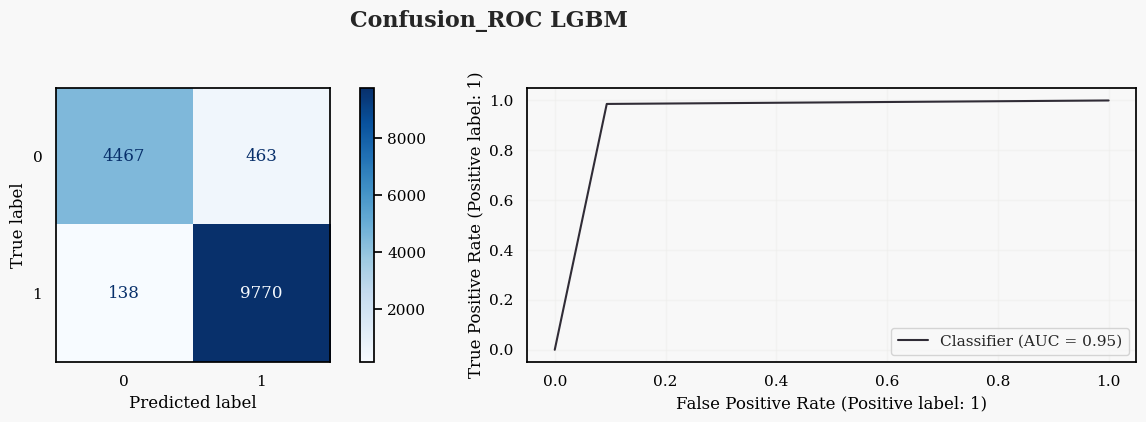

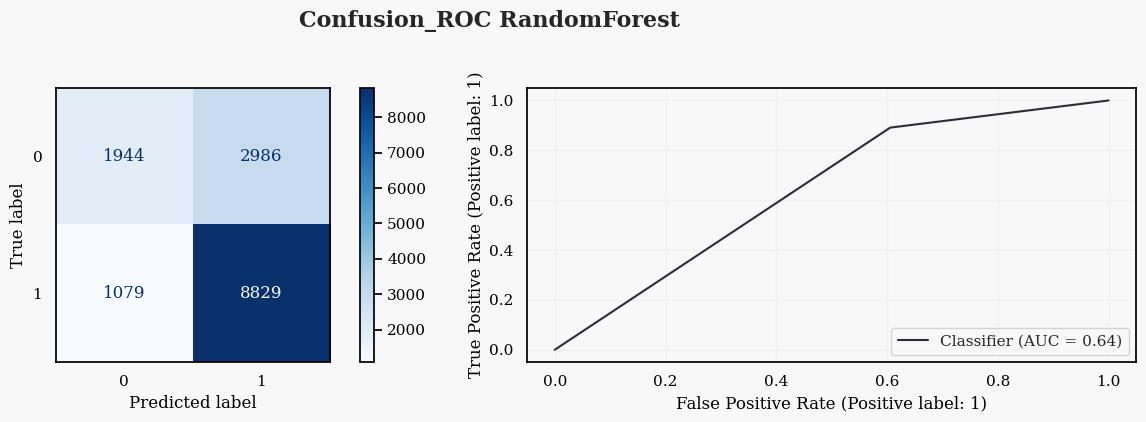

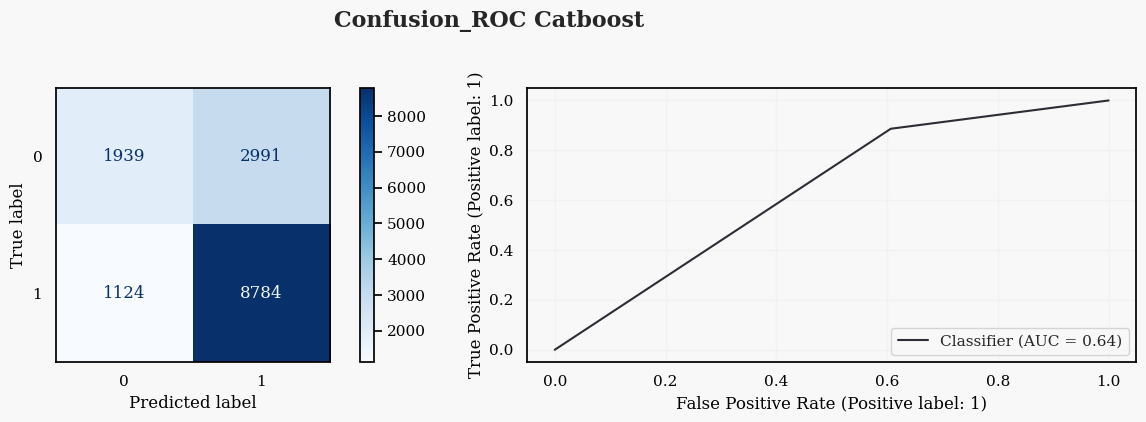

In [33]:
ensemble_pred = []
ensemble_scores = []

for model_name, model_info in models_ec1.items():
    model = model_info['model']
    pred = model.predict(X)
    ensemble_pred.append(pred)
    
    show_confusion_roc(pred, train['EC1'],model_name)


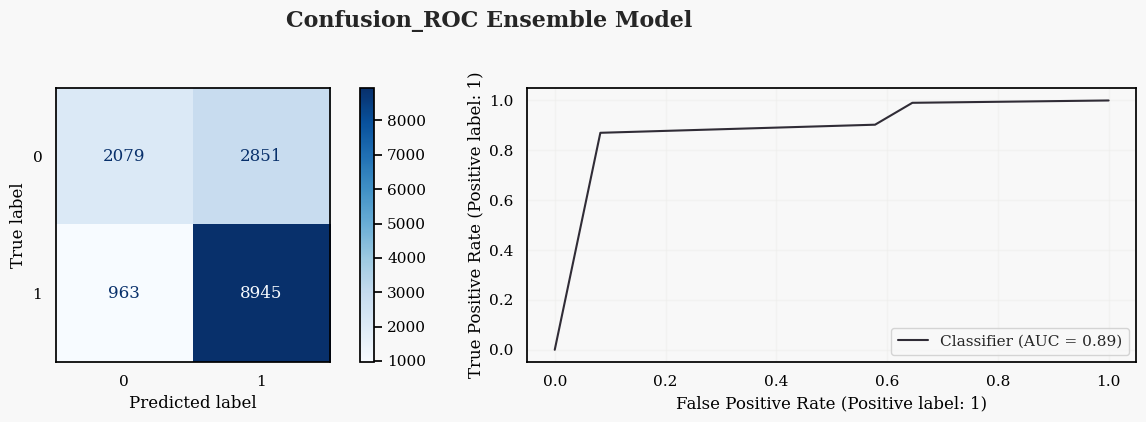

In [34]:
ensemble_pred_ec1 = np.mean(ensemble_pred, axis=0)
show_confusion_roc(ensemble_pred_ec1, train['EC1'],'Ensemble Model')

***Let's take a look at those models***

In [35]:
models_ec1

{'LGBM': {'model': <flaml.automl.model.LGBMEstimator at 0x7d133e0fb700>,
  'best_params': {'n_estimators': 145,
   'num_leaves': 1000,
   'min_child_samples': 6,
   'learning_rate': 0.028021152867265114,
   'log_max_bin': 8,
   'colsample_bytree': 0.21866938131471028,
   'reg_alpha': 0.0009765625,
   'reg_lambda': 0.0052634374032819245}},
 'RandomForest': {'model': <flaml.automl.model.RandomForestEstimator at 0x7d134851ef20>,
  'best_params': {'n_estimators': 19,
   'max_features': 0.23451855733595753,
   'max_leaves': 52,
   'criterion': 'entropy'}},
 'Catboost': {'model': <flaml.automl.model.CatBoostEstimator at 0x7d133dd02e60>,
  'best_params': {'early_stopping_rounds': 39,
   'learning_rate': 0.054091109291610796,
   'n_estimators': 84}}}

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Predict EC2</p>

In [36]:
models_ec2 = {}

y = train['EC2']

aml_lgb_cv_scores_EC2, aml_lgb_preds_EC2 = list(), list()
aml_rf_cv_scores_EC2, aml_rf_preds_EC2 = list(), list()
aml_cat_cv_scores_EC2, aml_cat_preds_EC2 = list(), list()

ens_cv_scores_EC2, ens_preds_EC2 = list(), list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for i, (train_ix, test_ix) in enumerate(skf.split(X.drop(['fr_COO', 'NumHeteroatoms', 'PEOE_VSA6'],axis=1), y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ##################
    ## FLAML (LGBM) ##
    ##################
    
    automl_lgbm = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['lgbm'],
                       "log_file_name": '',
                      }

    automl_lgbm.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_lgb_pred_1 = automl_lgbm.predict_proba(X_test)[:, 1]
    aml_lgb_pred_2 = automl_lgbm.predict_proba(test)[:, 1]

    aml_lgb_score_fold = roc_auc_score(Y_test, aml_lgb_pred_1)
    aml_lgb_cv_scores_EC2.append(aml_lgb_score_fold)
    aml_lgb_preds_EC2.append(aml_lgb_pred_2)
 
    models_ec2['LGBM'] = {'model': automl_lgbm.model, 'best_params': automl_lgbm.best_config}
    
    print('Fold', i, '==> FLAML (LGBM) oof ROC-AUC is ==>', aml_lgb_score_fold)

    # FLAML (Random Forest) 
  
    automl_rf = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['rf'],
                       "log_file_name": '',
                      }

    automl_rf.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_rf_pred_1 = automl_rf.predict_proba(X_test)[:, 1]
    aml_rf_pred_2 = automl_rf.predict_proba(test)[:, 1]

    aml_rf_score_fold = roc_auc_score(Y_test, aml_rf_pred_1)
    aml_rf_cv_scores_EC2.append(aml_rf_score_fold)
    aml_rf_preds_EC2.append(aml_rf_pred_2)

    models_ec2['RandomForest'] = {'model': automl_rf.model, 'best_params': automl_rf.best_config}
    print('Fold', i, '==> FLAML (RF) oof ROC-AUC is ==>', aml_rf_score_fold)

    # FLAML (CatBoost) 
    
    automl_cat = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['catboost'],
                       "log_file_name": '',
                      }

    automl_cat.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_cat_pred_1 = automl_cat.predict_proba(X_test)[:, 1]
    aml_cat_pred_2 = automl_cat.predict_proba(test)[:, 1]

    aml_cat_score_fold = roc_auc_score(Y_test, aml_cat_pred_1)
    aml_cat_cv_scores_EC2.append(aml_cat_score_fold)
    aml_cat_preds_EC2.append(aml_cat_pred_2)
    
    models_ec2['CatBoost'] = {'model': automl_cat.model, 'best_params': automl_cat.best_config}
    print('Fold', i, '==> FLAML (CatBoost) oof ROC-AUC is ==>', aml_cat_score_fold)
    
    # Average Ensemble 
    
    ens_pred_1 = (aml_lgb_pred_1 + aml_rf_pred_1 + aml_cat_pred_1 ) / 3
    ens_pred_2 = (aml_lgb_pred_2 + aml_rf_pred_2 + aml_cat_pred_2 ) / 3
    
    ens_score_fold = roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores_EC2.append(ens_score_fold)
    ens_preds_EC2.append(ens_pred_2)
    
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)

---------------------------------------------------------------
Fold 0 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.5861064071941318
Fold 0 ==> FLAML (RF) oof ROC-AUC is ==> 0.5843250414874881
Fold 0 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.5816478710154173
Fold 0 ==> Average Ensemble oof ROC-AUC score is ==> 0.586150914844149
---------------------------------------------------------------
Fold 1 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.578185811667645
Fold 1 ==> FLAML (RF) oof ROC-AUC is ==> 0.5805687371201573
Fold 1 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.5843776735498101
Fold 1 ==> Average Ensemble oof ROC-AUC score is ==> 0.5810438386223258
---------------------------------------------------------------
Fold 2 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.5960404440309236
Fold 2 ==> FLAML (RF) oof ROC-AUC is ==> 0.6012746849670819
Fold 2 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.6100211446661113
Fold 2 ==> Average Ensemble oof ROC-AUC score is ==> 0.605222089641233
-------------------------------

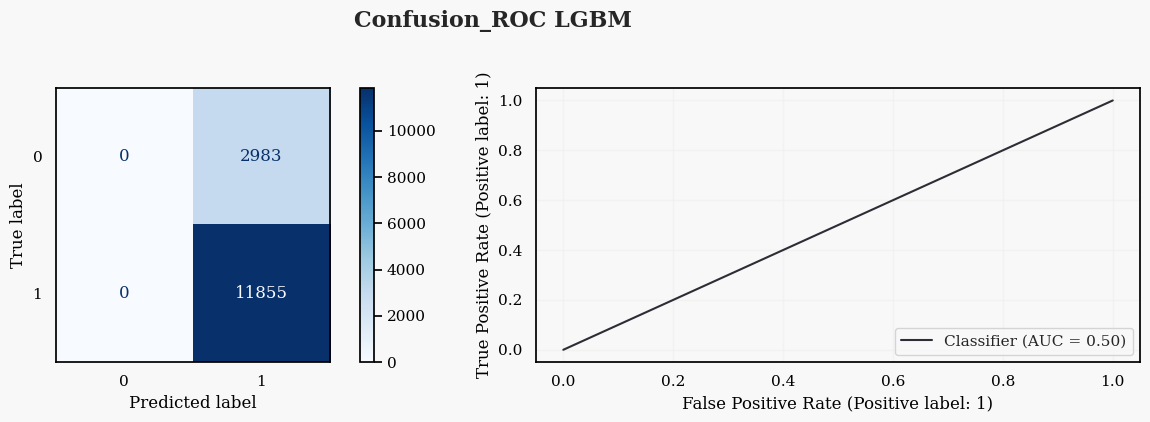

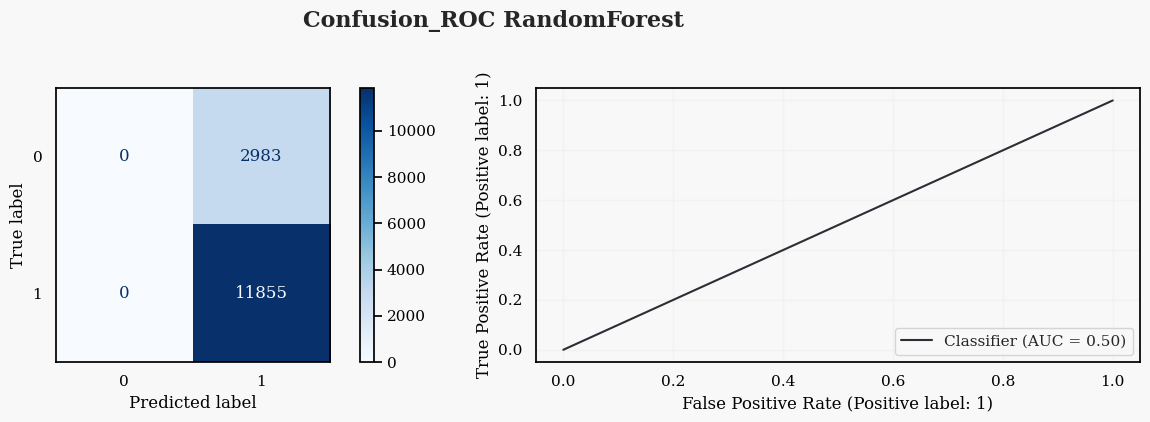

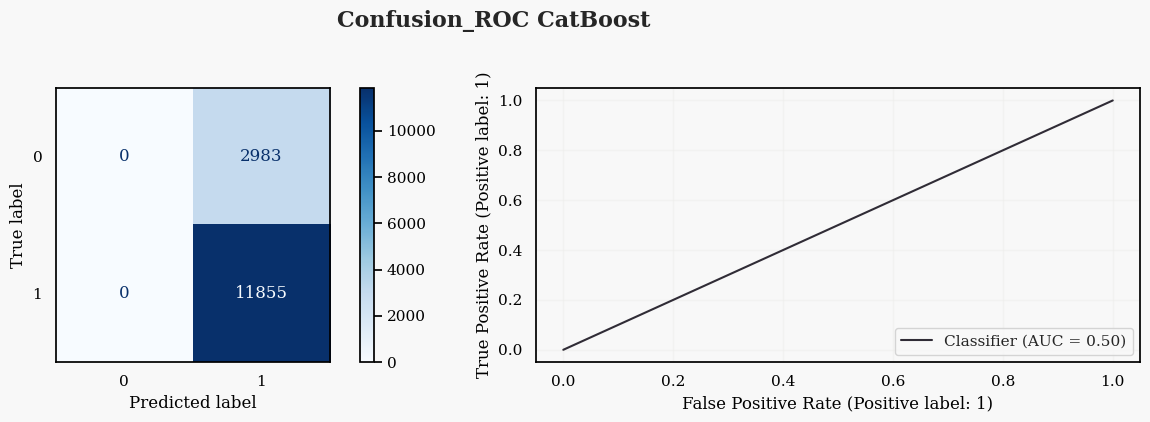

In [37]:
ensemble_pred = []
ensemble_scores = []

for model_name, model_info in models_ec2.items():
    model = model_info['model']
    pred = model.predict(X)
    ensemble_pred.append(pred)
    
    show_confusion_roc(pred, train['EC2'],model_name)


In [38]:
models_ec2

{'LGBM': {'model': <flaml.automl.model.LGBMEstimator at 0x7d1345f1b3a0>,
  'best_params': {'n_estimators': 83,
   'num_leaves': 23,
   'min_child_samples': 25,
   'learning_rate': 0.02193951001973069,
   'log_max_bin': 6,
   'colsample_bytree': 0.7530470371653892,
   'reg_alpha': 0.0009765625,
   'reg_lambda': 5.172997777907008}},
 'RandomForest': {'model': <flaml.automl.model.RandomForestEstimator at 0x7d133e98fbe0>,
  'best_params': {'n_estimators': 91,
   'max_features': 0.17334578740335238,
   'max_leaves': 14,
   'criterion': 'entropy'}},
 'CatBoost': {'model': <flaml.automl.model.CatBoostEstimator at 0x7d13471fb520>,
  'best_params': {'early_stopping_rounds': 10,
   'learning_rate': 0.00662129293751926,
   'n_estimators': 414}}}

In [39]:
ens_preds_test_EC1 = pd.DataFrame(ens_preds_EC1).apply(np.mean, axis = 0)
ens_preds_test_EC2 = pd.DataFrame(ens_preds_EC2).apply(np.mean, axis = 0)

sample['EC1'] = ens_preds_test_EC1
sample['EC2'] = ens_preds_test_EC2
sample.to_csv('FLAML_Ensemble_submission.csv', index = False)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">SHAP summary</p>

***This version of the notebook still has very much to be improved. I have consulted many high scoring notebooks for model selection, and I am currently trying to optimize the baseline model using optuna on a private notebook, which will appear in the next version.***

### ***Hope this helps! Please upvote if you like it!***